<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/7_Fine_CW_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [1]:
!nvidia-smi

Mon Jun 22 11:50:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from ham10000_utils_functions import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should 

In [3]:
tf.compat.v1.disable_eager_execution()

# Hyperparameters

In [4]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 7

LR = 3e-5 # Learning rate

# Data

In [5]:
!git clone https://github.com/filmerxyz/HAM10000_split

Cloning into 'HAM10000_split'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 10065 (delta 0), reused 1 (delta 0), pack-reused 10062
Receiving objects: 100% (10065/10065), 2.57 GiB | 62.78 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (10021/10021), done.


In [6]:
train_path = '/content/HAM10000_split/train' 
val_path = '/content/HAM10000_split/val'
test_path = '/content/HAM10000_split/test'

## Data Augmentation

In [7]:
train_aug = ImageDataGenerator(rescale=1./255,
                               rotation_range=360,
                               zoom_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect')

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_aug.flow_from_directory(train_path, 
                                                target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True,
                                                class_mode='categorical') 

val_generator = val_aug.flow_from_directory(val_path, 
                                              target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True,
                                              class_mode='categorical') 

test_generator = test_aug.flow_from_directory(test_path, 
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                               batch_size=1, 
                                               shuffle=False,
                                               class_mode=None) 

Found 6303 images belonging to 7 classes.
Found 2707 images belonging to 7 classes.
Found 1005 images belonging to 7 classes.


# Class Weights

In [9]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

In [10]:
class_weights_dict = { i : class_weights[i] for i in range(0, len(class_weights) ) }

# Model

## Build

In [11]:
def build_model():
  base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  
  for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
      layer.trainable = True
    else:
      layer.trainable = False

  average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  
  fc_layer = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(average_pooling_layer)
  fc_layer = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  fc_layer = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  bn_layer = tf.keras.layers.BatchNormalization()(fc_layer)
  dropout_layer = tf.keras.layers.Dropout(0.25)(bn_layer)
  prediction_layer = tf.keras.layers.Dense(units=7, activation='softmax', name='prediction')(dropout_layer)

  model = Model(inputs=base_model.input, outputs=prediction_layer)

  return model

In [12]:
model = build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94773248/94765736 [==============================] - 2s 0us/step


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Compile

In [14]:
model.compile(optimizer=Adam(LR), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Callbacks

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='7_fine_cw_resnet50_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7, patience=10, verbose=1, min_delta=1e-4, mode='min')

## Training

In [16]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS,
                    class_weight=class_weights_dict,
                    callbacks=[model_checkpoint, reduce_lr_rate],
                    verbose=1)

Epoch 1/100
197/197 [==============================] - 158s 800ms/step - loss: 2.2204 - accuracy: 0.1682 - val_loss: 1.6762 - val_accuracy: 0.1382 - lr: 3.0000e-05
Epoch 2/100
197/197 [==============================] - 130s 661ms/step - loss: 2.0444 - accuracy: 0.1921 - val_loss: 2.2725 - val_accuracy: 0.2667 - lr: 3.0000e-05
Epoch 3/100
197/197 [==============================] - 129s 657ms/step - loss: 1.9086 - accuracy: 0.2094 - val_loss: 3.3843 - val_accuracy: 0.0539 - lr: 3.0000e-05
Epoch 4/100
197/197 [==============================] - 129s 657ms/step - loss: 1.7725 - accuracy: 0.2413 - val_loss: 2.0185 - val_accuracy: 0.2375 - lr: 3.0000e-05
Epoch 5/100
197/197 [==============================] - 130s 661ms/step - loss: 1.7369 - accuracy: 0.2519 - val_loss: 1.9227 - val_accuracy: 0.3908 - lr: 3.0000e-05
Epoch 6/100
197/197 [==============================] - 131s 667ms/step - loss: 1.6507 - accuracy: 0.2710 - val_loss: 1.6098 - val_accuracy: 0.4248 - lr: 3.0000e-05
Epoch 7/100
197/

# Graph

## Accuracy

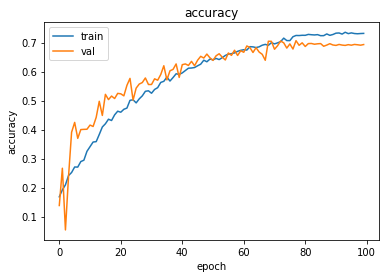

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## Loss

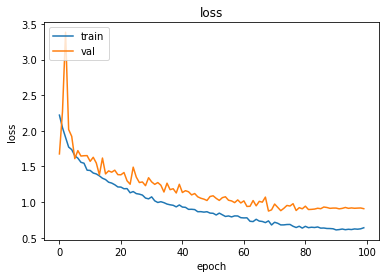

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluate

In [19]:
test_model = tf.keras.models.load_model('/content/7_fine_cw_resnet50_model.h5')

In [20]:
num_test_files = len(test_generator.filenames)

In [21]:
test_generator.reset()

In [22]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

## Confusion Matrix

### Without Normalize

Confusion matrix, without normalization
[[ 20   3   4   5   0   1   0]
 [  4  41   2   2   3   0   0]
 [  5   3  65   2  28   7   0]
 [  0   2   0   9   0   1   0]
 [  1   5   9   1  77  17   2]
 [  5  18  35  14 110 483   6]
 [  0   1   1   0   0   1  12]]


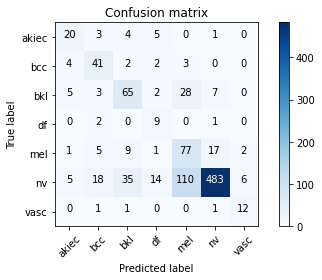

In [23]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

plot_confusion_matrix(cm, classes_names, False)

### With Normalize

Normalized confusion matrix
[[0.60606061 0.09090909 0.12121212 0.15151515 0.         0.03030303
  0.        ]
 [0.07692308 0.78846154 0.03846154 0.03846154 0.05769231 0.
  0.        ]
 [0.04545455 0.02727273 0.59090909 0.01818182 0.25454545 0.06363636
  0.        ]
 [0.         0.16666667 0.         0.75       0.         0.08333333
  0.        ]
 [0.00892857 0.04464286 0.08035714 0.00892857 0.6875     0.15178571
  0.01785714]
 [0.00745156 0.02682563 0.05216095 0.02086438 0.16393443 0.71982116
  0.00894188]
 [0.         0.06666667 0.06666667 0.         0.         0.06666667
  0.8       ]]


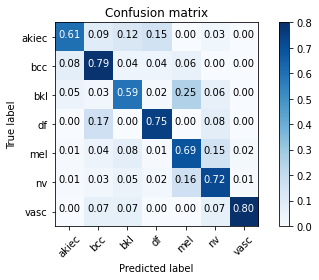

In [24]:
plot_confusion_matrix(cm, classes_names, True)

## Classification Report

In [25]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[ 20   3   4   5   0   1   0]
 [  4  41   2   2   3   0   0]
 [  5   3  65   2  28   7   0]
 [  0   2   0   9   0   1   0]
 [  1   5   9   1  77  17   2]
 [  5  18  35  14 110 483   6]
 [  0   1   1   0   0   1  12]]
Classification Report
              precision    recall  f1-score   support

       akiec       0.57      0.61      0.59        33
         bcc       0.56      0.79      0.66        52
         bkl       0.56      0.59      0.58       110
          df       0.27      0.75      0.40        12
         mel       0.35      0.69      0.47       112
          nv       0.95      0.72      0.82       671
        vasc       0.60      0.80      0.69        15

    accuracy                           0.70      1005
   macro avg       0.55      0.71      0.60      1005
weighted avg       0.79      0.70      0.73      1005



# Grad-CAM

In [28]:
last_conv2d = 'conv5_block3_3_conv'

## AKIEC

In [29]:
akiec_img = '/content/HAM10000_split/train/akiec/ISIC_0026492.jpg'

Model prediction:
	mel            	(4)	with probability 0.979
	bkl            	(2)	with probability 0.019
	bcc            	(1)	with probability 0.001
	nv             	(5)	with probability 0.001
	vasc           	(6)	with probability 0.000
Explanation for 'mel'


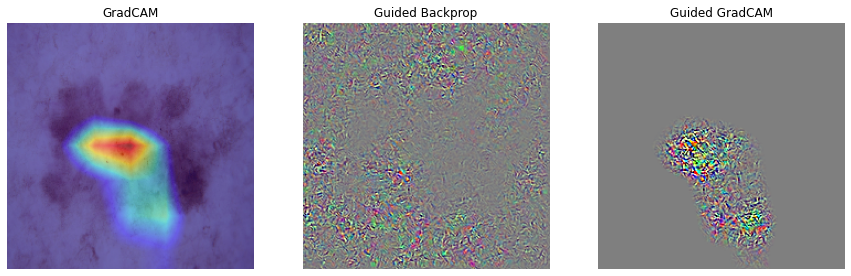

In [30]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, akiec_img, layer_name=last_conv2d)

## BCC

In [31]:
bcc_img = '/content/HAM10000_split/train/bcc/ISIC_0024332.jpg'

Model prediction:
	mel            	(4)	with probability 0.521
	bkl            	(2)	with probability 0.195
	df             	(3)	with probability 0.147
	akiec          	(0)	with probability 0.087
	nv             	(5)	with probability 0.027
Explanation for 'mel'


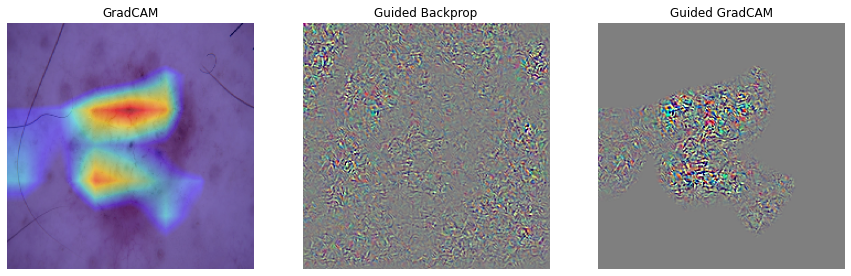

In [32]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bcc_img, layer_name=last_conv2d)

## BKL

In [33]:
bkl_img = '/content/HAM10000_split/train/bkl/ISIC_0025548.jpg'

Model prediction:
	mel            	(4)	with probability 0.843
	bkl            	(2)	with probability 0.091
	vasc           	(6)	with probability 0.043
	bcc            	(1)	with probability 0.016
	nv             	(5)	with probability 0.005
Explanation for 'mel'


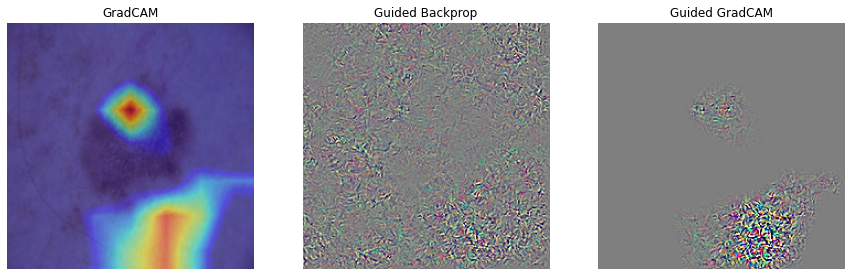

In [34]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bkl_img, layer_name=last_conv2d)

## DF

In [35]:
df_img = '/content/HAM10000_split/val/df/ISIC_0033626.jpg'

Model prediction:
	nv             	(5)	with probability 0.494
	mel            	(4)	with probability 0.492
	bkl            	(2)	with probability 0.009
	vasc           	(6)	with probability 0.002
	bcc            	(1)	with probability 0.002
Explanation for 'nv'


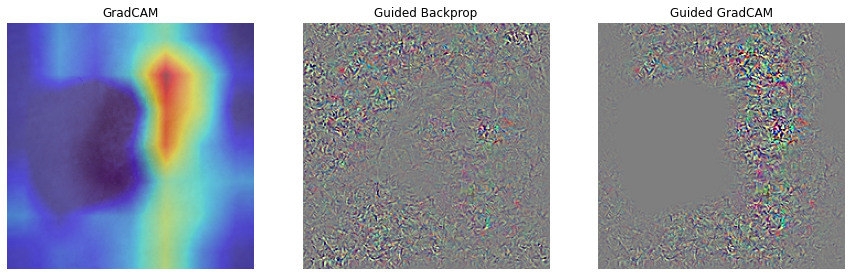

In [36]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, df_img, layer_name=last_conv2d)

## MEL

In [37]:
mel_img = '/content/HAM10000_split/train/mel/ISIC_0024516.jpg'

Model prediction:
	mel            	(4)	with probability 0.893
	nv             	(5)	with probability 0.058
	bkl            	(2)	with probability 0.022
	bcc            	(1)	with probability 0.015
	vasc           	(6)	with probability 0.008
Explanation for 'mel'


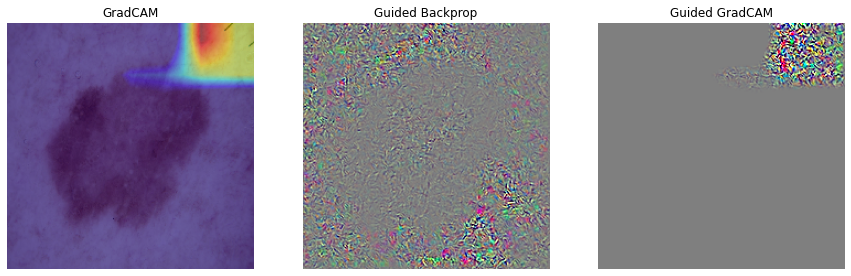

In [38]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, mel_img, layer_name=last_conv2d)

## NV

In [39]:
nv_img = '/content/HAM10000_split/val/nv/ISIC_0024349.jpg'

Model prediction:
	vasc           	(6)	with probability 0.622
	nv             	(5)	with probability 0.240
	bcc            	(1)	with probability 0.134
	mel            	(4)	with probability 0.003
	bkl            	(2)	with probability 0.001
Explanation for 'vasc'


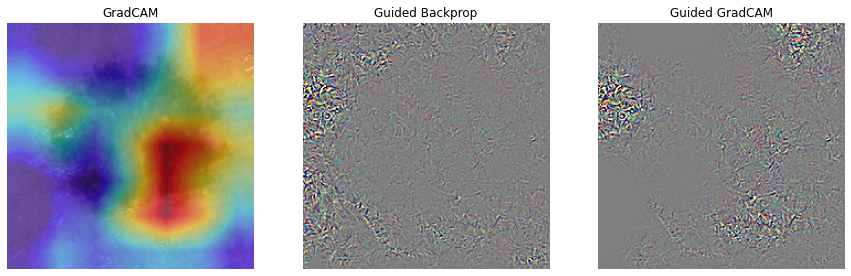

In [40]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, nv_img, layer_name=last_conv2d)

## VASC

In [41]:
vasc_img = '/content/HAM10000_split/test/vasc/ISIC_0025452.jpg'

Model prediction:
	nv             	(5)	with probability 0.861
	vasc           	(6)	with probability 0.096
	bcc            	(1)	with probability 0.032
	mel            	(4)	with probability 0.006
	bkl            	(2)	with probability 0.003
Explanation for 'nv'


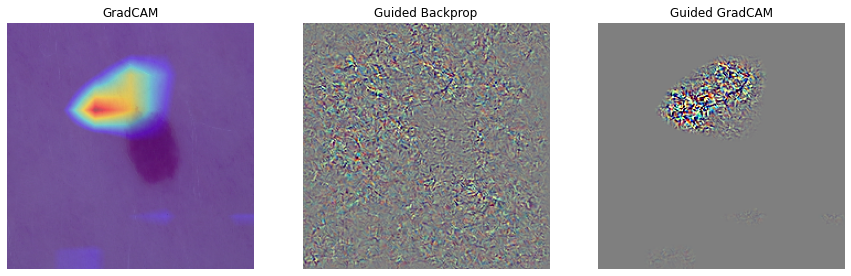

In [42]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, vasc_img, layer_name=last_conv2d)